# Model development
Notebook overview:
- create benchmark model
- error metrics
- create and test data loader
- train
- evaluate

In [1]:
import os.path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.utils.data

%matplotlib inline

In [2]:
data_dir = '../data/'

In [3]:
nasdaq_train = pd.read_csv(os.path.join(data_dir,'nasdaq_1d','train.csv'), index_col=0, header=None)
nasdaq_test = pd.read_csv(os.path.join(data_dir,'nasdaq_1d','test.csv'), index_col=0, header=None)

In [4]:
eurusd_train = pd.read_csv(os.path.join(data_dir,'eurusd_1d','train.csv'), index_col=0, header=None)
eurusd_test = pd.read_csv(os.path.join(data_dir,'eurusd_1d','test.csv'), index_col=0, header=None)

In [5]:
col2int = {k:v for k,v in zip(['Open','High','Low','Close','Gap','EMA','SMA','Momentum','RSI'], range(0,9))}
col2int

{'Open': 0,
 'High': 1,
 'Low': 2,
 'Close': 3,
 'Gap': 4,
 'EMA': 5,
 'SMA': 6,
 'Momentum': 7,
 'RSI': 8}

# Benchmark
Because the benchmark model is very simple and needed only in this notebook, I will define it here.

Simple Moving Average forecasting implementation:

In [6]:
class MA_regressor:
    def __init__(self, N=5):
        self.N = N
    
    def forward(self, price):
        return price[-self.N:].sum() / self.N
    
    def predict(self, data, steps=10):
        predictions = np.zeros((len(data),steps))
        for i in range(0,len(data)):
            d = data[i][:,col2int["Close"]]
            for j in range(0,steps):
                predictions[i][j] = self.forward(np.append(d, predictions[i][:j]))
        return predictions

In [10]:
sample, steps = 30, 3

benchmark = MA_regressor(10)
y = benchmark.predict([nasdaq_train.iloc[:sample].values], steps)[0]

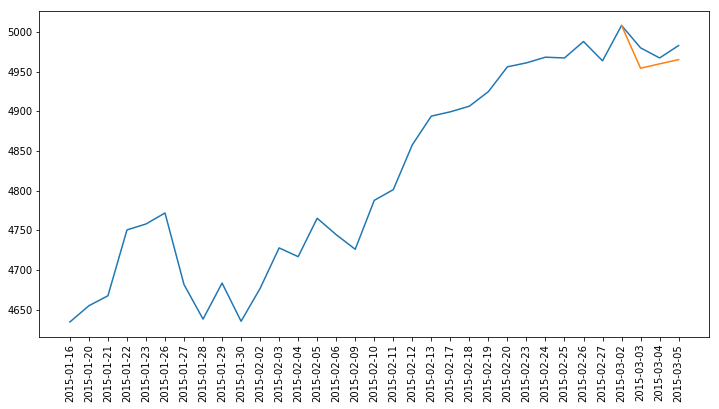

In [8]:
plt.figure(figsize=(12,6))
plt.xticks(rotation='vertical')
plt.plot(nasdaq_train.iloc[:sample+steps,3])

# Reconstruct index
y_series = nasdaq_train.iloc[sample-1:sample+steps,3].copy()
y_series.iloc[1:] = y

plt.plot(y_series)

# Metrics
The sample prediction is not successfull at all, we need some metric to optimize it.

Because this is an regression problem, we need a loss function describing how far we are from the correct answer.
I propose an $MSE$ metric with a sum reduction:

\begin{equation}
MSE = \frac{1}{2} \left( y - \hat{y} \right)^2
\end{equation}

It will allow us to compute a gradient that moves towards a better solution.

In [11]:
def loss_mse(y_hat, y):
    mse = 0.0
    for a,b in zip(y_hat, y):
        mse += 0.5 * (a - b)**2
    return mse

## Optimizing our benchmark
We need to find best parameters for our benchmark. Test function will calculate mean error for specific parameter.

In [12]:
target = nasdaq_train.iloc[sample:sample+steps,3].values
loss_mse(target, y)

515.8219224775455

In [13]:
def test(in_data, target, w=1):
    loss = [[], []]
    for i in range(2, 90):
        benchmark = MA_regressor(i)
        y = benchmark.predict([in_data.values], steps)[0]
        loss[0].append(i)
        loss[1].append(loss_mse(target, y) / w)
    return np.array(loss)

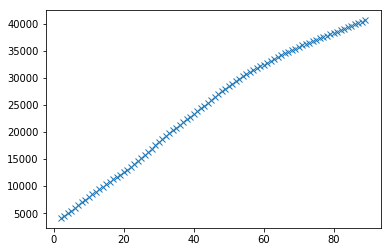

In [14]:
sample = 100
tests = 500

loss = test(nasdaq_train.iloc[:sample], nasdaq_train.iloc[sample:sample+steps,3].values, w=tests)
for offset in range(1,tests,2):
    loss[1] += test(nasdaq_train.iloc[offset:offset+sample],
                 nasdaq_train.iloc[offset+sample:offset+sample+steps,3].values, w=tests)[1]

plt.plot(*loss, 'x')

### Best benchmark model
It is clear that the lowest value of `N = 2` gives the best results over half of the NASDAQ train dataset.

Let's save it as our final benchmark.

In [15]:
benchmark = MA_regressor(N=2)

# LSTM model
Great, now that we know what the performance of our benchmark is, we can start developing a better solution.
Inside `model/model.py` there is an LSTMRegressor class, which is the model we will train.

I will train both of them and compare the results.

## Data Loader
Before we start we need to create a data loader for our problem.
The best approach is to use a sliding window over the dataset.

In [16]:
# A working copy from model/model.py
class SlidingWindowDataset(torch.utils.data.Dataset):
    def __init__(self, data, window_size):
        super().__init__()
        self.timeseries = data
        self.window = window_size
        self.length = len(self.timeseries)
    
    def __len__(self):
        return self.length - self.window + 1
        
    def __getitem__(self, index):
        if type(index) is slice:
            start = 0
            stop = self.length - self.window
            step = 1
            if index.start is not None:
                start = index.start
            if index.stop is not None:
                stop = index.stop
            if index.step is not None:
                step = index.step
            return np.array([self.timeseries[i:i+self.window] for i in range(start,stop,step)])
        else:
            last = index + self.window
            if index < 0 or last > self.length:
                raise IndexError
            return self.timeseries[index:last]

In [17]:
ds = SlidingWindowDataset(nasdaq_test.values, 5)
ds_loader = torch.utils.data.DataLoader(ds, batch_size=4)

In [18]:
sample = next(iter(ds_loader))
sample.shape, sample

(torch.Size([4, 5, 9]),
 tensor([[[ 6.5735e+03,  6.5867e+03,  6.3046e+03,  6.3330e+03,  1.0000e+00,
            7.2584e+03,  7.4221e+03, -1.9542e+02,  5.0000e+01],
          [ 6.2785e+03,  6.3552e+03,  6.1902e+03,  6.1929e+03,  3.0000e+00,
            7.2264e+03,  7.3989e+03, -1.4007e+02,  4.2857e+01],
          [ 6.2579e+03,  6.5555e+03,  6.2143e+03,  6.5544e+03,  2.0000e+00,
            7.2062e+03,  7.3729e+03,  3.6144e+02,  3.5714e+01],
          [ 6.4572e+03,  6.5830e+03,  6.3370e+03,  6.5795e+03,  1.0000e+00,
            7.1874e+03,  7.3521e+03,  2.5130e+01,  4.2857e+01],
          [ 6.6168e+03,  6.6842e+03,  6.5292e+03,  6.5845e+03,  1.0000e+00,
            7.1693e+03,  7.3333e+03,  5.0298e+00,  4.2857e+01]],
 
         [[ 6.2785e+03,  6.3552e+03,  6.1902e+03,  6.1929e+03,  3.0000e+00,
            7.2264e+03,  7.3989e+03, -1.4007e+02,  4.2857e+01],
          [ 6.2579e+03,  6.5555e+03,  6.2143e+03,  6.5544e+03,  2.0000e+00,
            7.2062e+03,  7.3729e+03,  3.6144e+02,  3.5714

## Uploading data
We need to store our input files on S3 server.

In [7]:
import sagemaker

sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/stock_forecasting'

role = sagemaker.get_execution_role()

In [8]:
in_data = {}
for directory in ['nasdaq_1d', 'eurusd_1d']:
    in_data.update({directory: sagemaker_session.upload_data(path=os.path.join(data_dir,directory), bucket=bucket, key_prefix=os.path.join(prefix,directory))})
in_data

{'nasdaq_1d': 's3://sagemaker-us-east-1-236375122127/sagemaker/stock_forecasting/nasdaq_1d',
 'eurusd_1d': 's3://sagemaker-us-east-1-236375122127/sagemaker/stock_forecasting/eurusd_1d'}

## Training
Before we run training job let's make sure that everything works as expected.
Here is a good place to test some different parameters as well.

In [17]:
import model.model as mdl

In [18]:
def train(model, outputs, train_loader, test_loader, use_cols, epochs, optimizer, loss_fn, device):
    model.train()
    for epoch in range(1, epochs + 1):
        total_loss = 0
        for batch in train_loader:         
            # Slice dataset for input and output
            batch_X = batch[:,:batch.shape[1]-outputs].to(device)
            batch_Y = batch[:,-outputs:].to(device)
            
            raw_y = model(batch_X[:,:,use_cols])
            y = mdl.denormalize(raw_y, batch_X[:,:,3])
            loss = loss_fn(y, batch_Y[:,:,3])
            loss.backward()
            
            # Update weights and reset gradients
            optimizer.step()
            optimizer.zero_grad()

            total_loss += loss.data.item()
            
        # Validation
        test_loss = 0
        with torch.no_grad():
            for test in test_loader:
                test_X = test[:,:test.shape[1]-outputs].to(device)
                test_Y = test[:,-outputs:].to(device)
                raw_y = model(test_X[:,:,use_cols])
                y = mdl.denormalize(raw_y, test_X[:,:,3])
                test_loss += loss_fn(y, test_Y[:,:,3]).data.item()
        print("Epoch: {},\tLoss: {},\tVal: {}".format(epoch, total_loss / len(train_loader), test_loss / len(test_loader)))

In [19]:
def get_data_loader(batch_size, sliding_window, dataframe):
    train_ds = mdl.SlidingWindowDataset(dataframe.values, sliding_window)
    return torch.utils.data.DataLoader(train_ds, batch_size=batch_size)

In [47]:
inputs = 100
outputs = 1
channels = [0,1,2,3,4,5,6,7,8]

model = mdl.LSTMRegressor(input_size=inputs,
                          input_channels=channels,
                          c_filters=5, c_kernel_size=3, lstm_layers=1, lstm_hidden=64, dropout=0.4,
                          output_size=outputs)
model = model.double()

In [45]:
loss_fn = torch.nn.MSELoss(reduction='sum')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader = get_data_loader(128, inputs+outputs, nasdaq_train)
test_loader = get_data_loader(128, inputs+outputs, nasdaq_test)
optimizer = torch.optim.Adam(model.parameters())

In [46]:
train(model, outputs, train_loader, test_loader, channels, 10, optimizer, loss_fn, device)

Epoch: 1,	Loss: 3555723.5169448117,	Val: 3101648.323734283
Epoch: 2,	Loss: 2108670.9985451987,	Val: 2787136.757923468
Epoch: 3,	Loss: 2044266.9525721301,	Val: 1881752.521310689
Epoch: 4,	Loss: 1607470.0808124642,	Val: 1585523.8601833247
Epoch: 5,	Loss: 1321962.5365359704,	Val: 1445157.9704693893
Epoch: 6,	Loss: 1234570.421785911,	Val: 1315298.9634101535
Epoch: 7,	Loss: 1060292.9790295456,	Val: 1269164.4133332039
Epoch: 8,	Loss: 954861.1432290438,	Val: 1246452.2161831472
Epoch: 9,	Loss: 846431.9941260559,	Val: 1210335.961664441
Epoch: 10,	Loss: 816016.7197172884,	Val: 1242989.3393979042


After some testing, I decided to leave all 9 channels enabled.
Other params are:
- inputs: 100
- outputs: 1
- c_filters: 5
- lstm_layers: 1
- lstm_hidden: 64
- dropout: 0.4

## Perform Training
Here we will train a model with 9 channels on EURUSD dataset, then on NASDAQ (with Volume dropped) and finally we will evaluate its performance.

Hyperparameters were set manually with some experimentation. Feel free to adjust them yourself.

In [52]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(entry_point="train.py",
                    source_dir="model",
                    role=role,
                    framework_version='1.2.0',
                    train_instance_count=1,
                    train_instance_type='ml.p2.xlarge',
                    hyperparameters={
                        'epochs': 40,
                        'batch-size': 128,
                        'input-size': 100,
                        'input-channels': '0,1,2,3,4,5,6,7,8',
                        'c-filters': 5,
                        'lstm-hidden': 64,
                        'lstm-layers': 1,
                        'output-size': 1,
                    })

In [53]:
estimator.fit({'training': in_data['nasdaq_1d']})

2020-01-31 22:24:37 Starting - Starting the training job...
2020-01-31 22:24:39 Starting - Launching requested ML instances......
2020-01-31 22:25:47 Starting - Preparing the instances for training.........
2020-01-31 22:27:18 Downloading - Downloading input data......
2020-01-31 22:28:16 Training - Downloading the training image............
2020-01-31 22:30:21 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-01-31 22:30:23,357 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-01-31 22:30:23,388 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-01-31 22:30:23,390 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-01-31 22:30:23,747 sagemaker-containers INFO     Module train does not provide a setup.py. 
Generating setup.py
2020-01-31 22:30:

In [54]:
estimator.fit({'training': in_data['eurusd_1d']})

2020-01-31 22:31:20 Starting - Starting the training job...
2020-01-31 22:31:22 Starting - Launching requested ML instances......
2020-01-31 22:32:25 Starting - Preparing the instances for training.........
2020-01-31 22:33:52 Downloading - Downloading input data...
2020-01-31 22:34:47 Training - Downloading the training image............
2020-01-31 22:36:52 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-01-31 22:36:53,432 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-01-31 22:36:53,459 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-01-31 22:36:53,461 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-01-31 22:36:53,767 sagemaker-containers INFO     Module train does not provide a setup.py. 
Generating setup.py
2020-01-31 22:36:53

### Model S3 Location
For our web application deployment we will use S3 location of our estimator:

**Copy result of the cell below - it is required in the next notebook!**

In [55]:
estimator.model_data

's3://sagemaker-us-east-1-236375122127/pytorch-training-2020-01-31-22-31-20-594/output/model.tar.gz'

## Evaluation
Here we deploy our estimator, test how does it perform on both NASDAQ and EURUSD. After everything runs without errors, we will compare the result against our benchmark.

In [56]:
predictor = estimator.deploy(instance_type='ml.p2.xlarge', initial_instance_count=1)

---------------------!

In [57]:
# Should match input + output size
ds_eurusd = SlidingWindowDataset(eurusd_test.values, 101)
ds_nasdaq = SlidingWindowDataset(nasdaq_test.values, 101)

In [59]:
predictor.predict(ds_eurusd[:3][:,:100])

array([[0.18912772],
       [0.45490125],
       [0.50761064]])

In [60]:
predictor.predict(ds_nasdaq[:3][:,:100])

array([[-0.98744065],
       [-1.25032393],
       [-1.39002417]])

## Benchmark vs LSTM Solution

In [61]:
def test(ds, in_len=100, out_len=1):
    test_y = ds
    x = test_y[:,:in_len]
    test_y = test_y[:,:,col2int['Close']]
    
    ma_y = benchmark.predict(x, out_len)
    model_y = predictor.predict(x)
    model_y = mdl.denormalize(torch.from_numpy(model_y), torch.from_numpy(x[:,:,3]))
    
    ax = np.arange(sum(test_y.shape) - 1)
    y = test_y[0]
    y = np.append(y, [test_y[i,-1] for i in range(1,test_y.shape[0])])
    return ax, y, ma_y.squeeze(), model_y.squeeze().numpy()

In [63]:
ax, y, ma_y, model_y = test(ds_eurusd[:20], in_len=100, out_len=1)

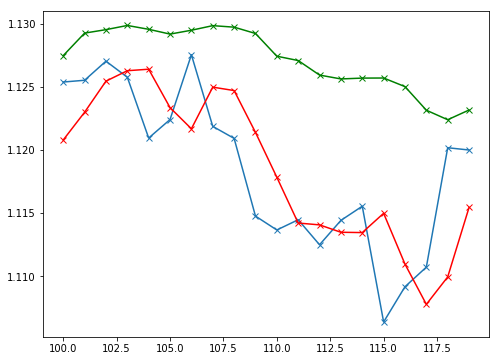

In [64]:
plt.figure(figsize=(8,6))
plt.plot(ax[-20:], y[-20:], '-x')
plt.plot(ax[-20:], ma_y, 'r-x')
plt.plot(ax[-20:], model_y, 'g-x')

In [67]:
loss_mse(y[-20:], ma_y), loss_mse(y[-20:], model_y)

(1936889.9546831888, 8608888.91211852)

In [69]:
ax, y, ma_y, model_y = test(ds_nasdaq[10:50], in_len=100, out_len=1)

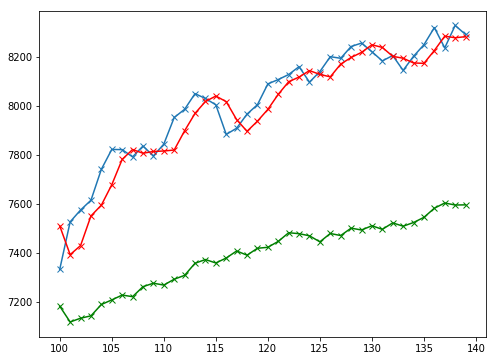

In [70]:
plt.figure(figsize=(8,6))
plt.plot(ax[-40:], y[-40:], '-x')
plt.plot(ax[-40:], ma_y, 'r-x')
plt.plot(ax[-40:], model_y, 'g-x')

In [71]:
loss_mse(y[-40:], ma_y), loss_mse(y[-40:], model_y)

(120268.06980236899, 7972754.094499213)

## Clean-up
We will not need this endpoint anymore, so let's remove it.

In [72]:
estimator.delete_endpoint()

# Summary
Model is ready to deploy. Final deployment steps will be performed in the `WebApp.ipynb` notebook.